## Libs import and config

In [1]:
import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import os, re
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 500)
pd.set_option('display.max_rows', 500)

In [2]:
filepath = '/Users/leoguillaume/Documents/openclassrooms-projects/openclassrooms-project-2/data/Projet+Python_Dataset_Edstats_csv/'

## Data import

In [3]:
csv_list = os.listdir(filepath)

In [4]:
for csv in csv_list:
    locals()[csv[:-4]] = pd.read_csv(os.path.join(filepath,csv))

In [5]:
for csv in csv_list:
    print(csv+'\n'+40*'-')
    locals()[csv[:-4]].info()
    print('\n')

EdStatsCountry.csv
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 32 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Country Code                                       241 non-null    object 
 1   Short Name                                         241 non-null    object 
 2   Table Name                                         241 non-null    object 
 3   Long Name                                          241 non-null    object 
 4   2-alpha code                                       238 non-null    object 
 5   Currency Unit                                      215 non-null    object 
 6   Special Notes                                      145 non-null    object 
 7   Region                                             214 non-null    object 
 8   Income Group                  

## Tables shapes

In [195]:
print('Row\n' + 30*'-')
for csv in csv_list:
    print(f"{csv}: {str(locals()[csv[:-4]].shape[0])}")
    
print('\nFeaures\n' + 30*'-')
for csv in csv_list:
    print(f"{csv}: {str(locals()[csv[:-4]].shape[1])}")  

Row
------------------------------
EdStatsCountry.csv: 241
EdStatsCountry-Series.csv: 613
EdStatsData.csv: 886930
EdStatsFootNote.csv: 643638
EdStatsSeries.csv: 3665

Feaures
------------------------------
EdStatsCountry.csv: 32
EdStatsCountry-Series.csv: 4
EdStatsData.csv: 30
EdStatsFootNote.csv: 5
EdStatsSeries.csv: 22


## Tables contents

EdStatsSeries : informations about indicators (descriptions) >> for feature selection

EdStatsCountry : country statistics (use incomes group)

EdStatsCountrySeries : sources of StatSeries >> useless

EdStatsData : country education statistics >> main data

EdStatsFootNote : year of country indicator of EdStatsData are present >> for filtered EdStatsData with % data score

## Datapoints (~ missing values)

In [ ]:
EdStatsData.drop(columns = 'Unnamed: 69', inplace = True)
EdStatsData.sort_index(axis = 1, inplace = True)

### Per years

In [16]:
filling_rate_per_years = EdStatsData.iloc[:, :-4].notna().sum(axis = 0) / EdStatsData.shape[0]

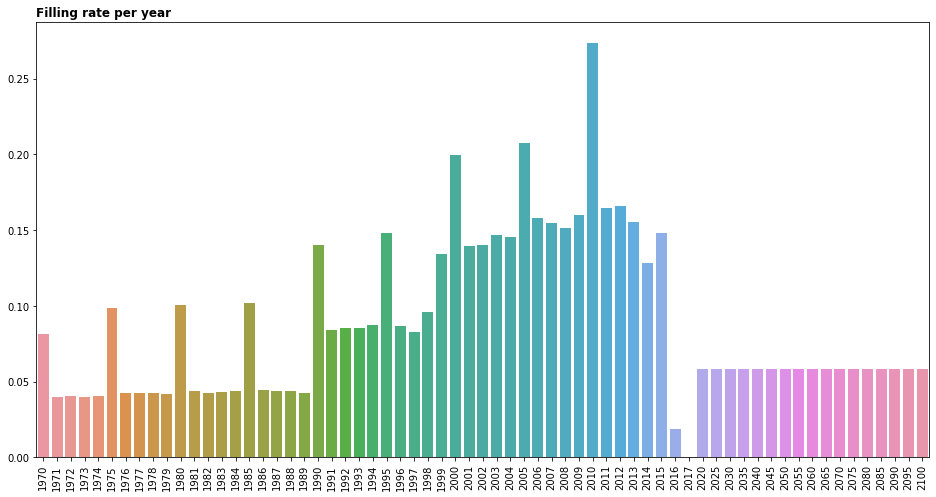

In [65]:
plt.figure(figsize = (16, 8))
sns.barplot(x = filling_rate_per_years.index, y = filling_rate_per_years.values)
plt.xticks(rotation = 90)
plt.title('Filling rate per year', fontweight = 'bold', loc = 'left')
plt.show()

### Per indicators

In [62]:
values_per_indicator = EdStatsData['Indicator Code'].value_counts()[0] * EdStatsData.iloc[:, :-4].shape[1]

In [63]:
values_per_indicator = EdStatsData['Indicator Code'].value_counts()[0] * EdStatsData.iloc[:, :-4].shape[1]
filling_rate_per_indicator = (EdStatsData.iloc[:, :-4].notna().groupby(EdStatsData['Indicator Code'], sort = False).sum().sum(axis = 1) / values_per_indicator).sort_values()

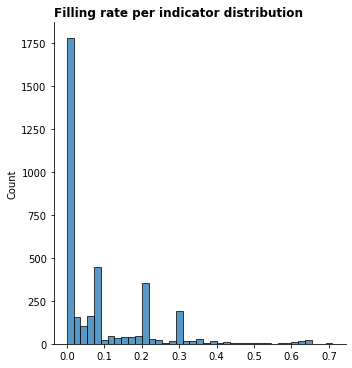

In [75]:
sns.displot(filling_rate_per_indicator)
plt.title('Filling rate per indicator distribution', fontweight = 'bold', loc = 'left')
plt.show()

In [83]:
f'% of indicators with more 50% of filled values: {(filling_rate_per_indicator > 0.5).sum() / len(filling_rate_per_indicator):.2%}'

'% of indicators with more 50% of filled values: 1.69%'

### Per country

In [96]:
values_per_country = EdStatsData['Country Name'].value_counts()[0] * EdStatsData.iloc[:, :-4].shape[1]

In [99]:
filling_rate_per_country = (EdStatsData.iloc[:, :-4].notna().groupby(EdStatsData['Country Name'], sort = False).sum().sum(axis = 1) / values_per_country).sort_values()

In [ ]:
filling_rate_per_contry = (EdStatsData.iloc[:, :-4].notna().groupby(EdStatsData['Indicator Code'], sort = False).sum().sum(axis = 1) / values_per_indicator).sort_values()

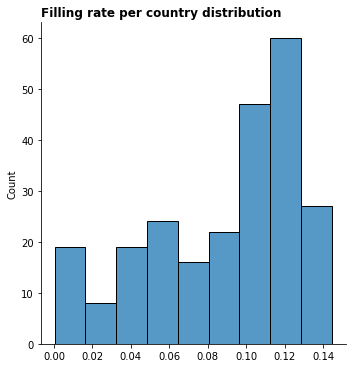

In [103]:
sns.displot(filling_rate_per_country)
plt.title('Filling rate per country distribution', fontweight = 'bold', loc = 'left')
plt.show()

#### World map of datapoints

In [106]:
geolocator = Nominatim(user_agent="openclassroom_project_2")

In [129]:
def get_loc(country:str, geo_dict:dict):
    location = geolocator.geocode(country)
    latitude = location.latitude
    longitude = location.longitude
    geo_dict[country] = dict()
    geo_dict[country]['latitude'] = latitude
    geo_dict[country]['longitude'] = longitude
    geo_dict[country]['datapoints'] = datapoints
    
    return geo_dict
    
geo_dict = dict()
for country, datapoints in filling_rate_per_country.iteritems():
    try:
        geo_dict = get_loc(country, geo_dict)
    except:
        try:
            geo_dict = get_loc(country.split(',')[0], geo_dict)
        except Exception as e:                                    
            print(f'Error {e} for {country}')

Error 'NoneType' object has no attribute 'latitude' for Virgin Islands (U.S.)
Error 'NoneType' object has no attribute 'latitude' for Europe & Central Asia (excluding high income)
Error 'NoneType' object has no attribute 'latitude' for East Asia & Pacific (excluding high income)
Error 'NoneType' object has no attribute 'latitude' for Upper middle income
Error 'NoneType' object has no attribute 'latitude' for Sub-Saharan Africa
Error 'NoneType' object has no attribute 'latitude' for Sub-Saharan Africa (excluding high income)
Error 'NoneType' object has no attribute 'latitude' for Low & middle income
Error 'NoneType' object has no attribute 'latitude' for OECD members
Error 'NoneType' object has no attribute 'latitude' for Lower middle income
Error 'NoneType' object has no attribute 'latitude' for Heavily indebted poor countries (HIPC)
Error 'NoneType' object has no attribute 'latitude' for Least developed countries: UN classification
Error 'NoneType' object has no attribute 'latitude' f

In [131]:
m = folium.Map(location=[12,1], zoom_start=2)
for country in geo_dict.keys():
    folium.Circle(location=[geo_dict[country]['latitude'], geo_dict[country]['longitude']],
                  popup=country,
                  radius= geo_dict[country]['datapoints'] * 1000000,
                  color='crimson',
                  fill=True,
                  fill_color='crimson').add_to(m)

In [134]:
m

## Duplicates values

In [145]:
index_null_row = EdStatsData.iloc[:, :-4].isna().sum(axis = 1)[EdStatsData.iloc[:, :-4].isna().sum(axis = 1) == 65].index
EdStatsData_notna = EdStatsData[~EdStatsData.index.isin(index_null_row)]

In [146]:
f"% of duplicates values in EdStatsData: {(len(EdStatsData_notna) - len(EdStatsData_notna.drop(columns = ['Indicator Name', 'Indicator Code']).drop_duplicates())) / len(EdStatsData_notna):.2%}"

'% of duplicates values in EdStatsData: 3.48%'

> Some indicators measure the same things!

## Data cleaning 

Restrict analysis on 1990 to 2015

In [147]:
for column in EdStatsData:
    try:
        if int(column) > 2015 or int(column) < 1990:
            EdStatsData.drop(columns = column, inplace = True)
    except:
        pass

### Add filling rate (all year and 2010) by indicators in EdStatsSeries

2010 pour les variables fixes

In [184]:
values_per_indicator_all_years = EdStatsData['Indicator Code'].value_counts()[0] * EdStatsData.iloc[:,:26].shape[1]
filling_rate = (EdStatsData.iloc[:,:26].notna().groupby(EdStatsData['Indicator Code'], sort = False).sum().sum(axis = 1) / values_per_indicator_all_years)

In [181]:
EdStatsSeries.set_index('Series Code', inplace = True)

In [182]:
EdStatsSeries['filling_rate'] = filling_rate

In [192]:
values_per_indicator_2010 = EdStatsData['Indicator Code'].value_counts()[0]
filling_rate_2010 = EdStatsData['2010'].notna().groupby(EdStatsData['Indicator Code'], sort = False).sum() / values_per_indicator_2010

In [193]:
EdStatsSeries['filling_rate_2010'] = filling_rate_2010

## Variables selection

In [196]:
def feature_research(pattern:str, topic:str = None) -> 'feature_list':
    feature_list = list()
    for row in EdStatsSeries.iterrows():
        if topic != None:
            if re.search('percentage', row[1]['Long definition'].lower()) \
            and re.search(pattern, row[1]['Long definition'].lower()) \
            and row[1]['Topic'] == topic:
                feature_list.append(row[0])
        else:
            if re.search('percentage', row[1]['Long definition'].lower()) \
            and re.search(pattern, row[1]['Long definition'].lower()):
                feature_list.append(row[0])
    return feature_list

In [197]:
upper_secondary_feature_list = feature_research('upper secondary', topic = 'Secondary')

In [199]:
EdStatsSeries.loc[EdStatsSeries.index.isin(upper_secondary_feature_list)][['Long definition',
                                                                           'filling_rate_2010',
                                                                           'filling_rate',]].sort_values(['filling_rate_2010',
                                                                                                  'filling_rate'], 
                                                                                                 ascending = [False, False])


,Long definition,filling_rate_2010,filling_rate
Series Code,,,
UIS.FEP.3.GPV,Number of female general education students at the upper secondary level expressed as a percentage of the total number of general education students (male and female) at the upper secondary level in a given school year.,0.752066,0.486809
UIS.FEP.3,Number of female students at the upper secondary level expressed as a percentage of the total number of students (male and female) at the upper secondary level in a given school year.,0.719008,0.507788
SE.SEC.ENRR.UP,"Total enrollment in upper secondary education, regardless of age, expressed as a percentage of the total population of official upper secondary education age.",0.702479,0.524793
SE.SEC.ENRR.UP.MA,"Total male enrollment in upper secondary education, regardless of age, expressed as a percentage of the male population of official upper secondary education age.",0.698347,0.512397
UIS.GTVP.3.GPV,"Total number of students enrolled in general programmes at the upper secondary education level, expressed as a percentage of the total number of students enrolled in all programmes (vocational and general) at the upper secondary level. General education is designed to develop learners’ general knowledge, skills and competencies and literacy and numeracy skills, often to prepare students for more advanced educational programmes at the same or higher ISCED levels and to lay the foundation for ...",0.690083,0.449142
UIS.GTVP.3.GPV.M,"Total number of male students enrolled in general programmes at the upper secondary education level, expressed as a percentage of the total number of male students enrolled in all programmes (vocational and general) at the upper secondary level. General education is designed to develop learners’ general knowledge, skills and competencies and literacy and numeracy skills, often to prepare students for more advanced educational programmes at the same or higher ISCED levels and to lay the found...",0.690083,0.441990
UIS.GTVP.3.GPV.F,"Total number of female students enrolled in general programmes at the upper secondary education level, expressed as a percentage of the total number of female students enrolled in all programmes (vocational and general) at the upper secondary level. General education is designed to develop learners’ general knowledge, skills and competencies and literacy and numeracy skills, often to prepare students for more advanced educational programmes at the same or higher ISCED levels and to lay the f...",0.690083,0.441831
UIS.GTVP.3.V,"Total number of students enrolled in vocational programmes at the upper secondary education level, expressed as a percentage of the total number of students enrolled in all programmes (vocational and general) at the upper secondary level. Vocational education is designed for learners to acquire the knowledge, skills and competencies specific to a particular occupation or trade or class of occupations or trades. Vocational education may have work-based components (e.g. apprenticeships). Succe...",0.590909,0.385887
UIS.GTVP.3.V.M,"Total number of male students enrolled in vocational programmes at the upper secondary education level, expressed as a percentage of the total number of male students enrolled in all programmes (vocational and general) at the upper secondary level. Vocational education is designed for learners to acquire the knowledge, skills and competencies specific to a particular occupation or trade or class of occupations or trades. Vocational education may have work-based components (e.g. apprenticeshi...",0.590909,0.379212


In [229]:
e = pd.DataFrame(columns = t['Country Name'].unique(), index = t['Indicator Code'].unique())

In [238]:
e.transpose().corr()['SE.SEC.ENRR.UP'].sort_values()

UIS.ROFST.3.M.CP    -0.904509
UIS.ROFST.3.CP      -0.902175
UIS.ROFST.3.F.CP    -0.893698
UIS.GTVP.3.GPV.M    -0.409839
UIS.GTVP.3.GPV      -0.364819
UIS.GTVP.3.GPV.F    -0.298791
UIS.FOFSTP.3        -0.233043
UIS.PRP.3           -0.207350
UIS.FEP.3.V          0.043068
UIS.GTVP.3.V.F       0.322566
UIS.GTVP.3.V         0.397389
UIS.GTVP.3.V.M       0.455186
UIS.FEP.3            0.462947
UIS.FEP.3.GPV        0.670288
UIS.NERA.3.M         0.891068
UIS.NER.3.M          0.900872
UIS.NERA.3           0.923931
UIS.NER.3            0.931166
UIS.NERA.3.F         0.939681
UIS.NER.3.F          0.942965
SE.SEC.ENRR.UP.MA    0.987159
SE.SEC.ENRR.UP       1.000000
Name: SE.SEC.ENRR.UP, dtype: float64

In [230]:
for country in e.columns:
    e[country] = t[t['Country Name'] == country].drop('Country Name', 1).set_index('Indicator Code')

In [219]:
for country in t['Country Name'].unique():
    t[t['Country Name'] == country]['2010']

In [217]:
t['Indicator Code'].unique()

array(['UIS.NERA.3', 'UIS.NERA.3.F', 'UIS.NERA.3.M', 'SE.SEC.ENRR.UP',
       'SE.SEC.ENRR.UP.MA', 'UIS.NER.3', 'UIS.NER.3.F', 'UIS.NER.3.M',
       'UIS.FOFSTP.3', 'UIS.PRP.3', 'UIS.GTVP.3.GPV.F', 'UIS.GTVP.3.V.F',
       'UIS.GTVP.3.GPV.M', 'UIS.GTVP.3.V.M', 'UIS.GTVP.3.GPV',
       'UIS.GTVP.3.V', 'UIS.FEP.3', 'UIS.FEP.3.GPV', 'UIS.FEP.3.V',
       'UIS.ROFST.3.CP', 'UIS.ROFST.3.F.CP', 'UIS.ROFST.3.M.CP'],
      dtype=object)

In [216]:
t['Country Name'].unique()

array(['Arab World', 'East Asia & Pacific',
       'East Asia & Pacific (excluding high income)', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)', 'European Union',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Least developed countries: UN classification',
       'Low & middle income', 'Low income', 'Lower middle income',
       'Middle East & North Africa',
       'Middle East & North Africa (excluding high income)',
       'Middle income', 'North America', 'OECD members', 'South Asia',
       'Sub-Saharan Africa', 'Sub-Saharan Africa (excluding high income)',
       'Upper middle income', 'World', 'Afghanistan', 'Albania',
       'Algeria', 'American Samoa', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain',


In [215]:
t = EdStatsData[['Country Name','Indicator Code','2010']][EdStatsData['Indicator Code'].isin(upper_secondary_feature_list)]

In [336]:
EdStatsSeries[EdStatsSeries.Topic == 'Infrastructure: Communications']

,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,Limitations and exceptions,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20,filling_rate,filling_rate_2010
Series Code,,,,,,,,,,,,,,,,,,,,,,
IT.CMP.PCMP.P2,Infrastructure: Communications,Personal computers (per 100 people),NaN,Personal computers are self-contained computers designed to be used by a single individual.,NaN,Annual,NaN,NaN,Weighted average,NaN,NaN,Restricted use: Please cite the International Telecommunication Union for third-party use of these data. This indicator is not available in the World Development Indicators time series database.,"International Telecommunication Union, World Telecommunication/ICT Development Report and database.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.417832,0.000000
IT.NET.USER.P2,Infrastructure: Communications,Internet users (per 100 people),NaN,"Internet users are individuals who have used the Internet (from any location) in the last 3 months. The Internet can be used via a computer, mobile phone, personal digital assistant, games machine, digital TV etc.",NaN,Annual,NaN,NaN,Weighted average,"Operators have traditionally been the main source of telecommunications data, so information on subscriptions has been widely available for most countries. This gives a general idea of access, but a more precise measure is the penetration rate - the share of households with access to telecommunications. During the past few years more information on information and communication technology use has become available from household and business surveys. Also important are data on actual use of t...",NaN,Please cite the International Telecommunication Union for third-party use of these data.,"International Telecommunication Union, World Telecommunication/ICT Development Report and database.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.811030,0.938017


In [22]:
tertiary_secondary_feature_list = feature_research('tertiary')

In [23]:
EdStatsSeries.loc[EdStatsSeries['Series Code'].isin(tertiary_secondary_feature_list)][['Series Code', 'Long definition']]

,Series Code,Long definition
270,BAR.TER.CMPT.1519.FE.ZS,Percentage of female population age 15-19 with tertiary schooling. Completed Tertiary
271,BAR.TER.CMPT.1519.ZS,Percentage of population age 15-19 with tertiary schooling. Completed Tertiary
272,BAR.TER.CMPT.15UP.FE.ZS,Percentage of female population age 15+ with tertiary schooling. Completed Tertiary
273,BAR.TER.CMPT.15UP.ZS,Percentage of population age 15+ with tertiary schooling. Completed Tertiary
274,BAR.TER.CMPT.2024.FE.ZS,Percentage of female population age 20-24 with tertiary schooling. Completed Tertiary
275,BAR.TER.CMPT.2024.ZS,Percentage of population age 20-24 with tertiary schooling. Completed Tertiary
276,BAR.TER.CMPT.2529.FE.ZS,Percentage of female population age 25-29 with tertiary schooling. Completed Tertiary
277,BAR.TER.CMPT.2529.ZS,Percentage of population age 25-29 with tertiary schooling. Completed Tertiary
278,BAR.TER.CMPT.25UP.FE.ZS,Percentage of female population age 25+ with tertiary schooling. Completed Tertiary
279,BAR.TER.CMPT.25UP.ZS,Percentage of population age 25+ with tertiary schooling. Completed Tertiary


## Get languages

In [24]:
import pycountry

In [25]:
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_2

In [26]:
codes = {country:countries.get(country, 'Unknown code') for country in EdStatsData['Country Name'].unique()}

In [27]:
import lxml.etree
import urllib.request

def get_territory_languages():
    url = "https://raw.githubusercontent.com/unicode-org/cldr/master/common/supplemental/supplementalData.xml"
    langxml = urllib.request.urlopen(url)
    langtree = lxml.etree.XML(langxml.read())

    territory_languages = {}
    for t in langtree.find('territoryInfo').findall('territory'):
        langs = {}
        for l in t.findall('languagePopulation'):
            langs[l.get('type')] = {
                'percent': float(l.get('populationPercent')),
                'official': bool(l.get('officialStatus'))
            }
        territory_languages[t.get('type')] = langs
    return territory_languages

In [28]:
territory_languages = get_territory_languages()

In [29]:
language_dict = dict()
for country in codes.keys():
    try:
        language_dict[country] = list(territory_languages[codes[country]].keys())[0]
    except Exception as e:
        print(f'Error {e} for {country}')

Error 'Unknown code' for Arab World
Error 'Unknown code' for East Asia & Pacific
Error 'Unknown code' for East Asia & Pacific (excluding high income)
Error 'Unknown code' for Euro area
Error 'Unknown code' for Europe & Central Asia
Error 'Unknown code' for Europe & Central Asia (excluding high income)
Error 'Unknown code' for European Union
Error 'Unknown code' for Heavily indebted poor countries (HIPC)
Error 'Unknown code' for High income
Error 'Unknown code' for Latin America & Caribbean
Error 'Unknown code' for Latin America & Caribbean (excluding high income)
Error 'Unknown code' for Least developed countries: UN classification
Error 'Unknown code' for Low & middle income
Error 'Unknown code' for Low income
Error 'Unknown code' for Lower middle income
Error 'Unknown code' for Middle East & North Africa
Error 'Unknown code' for Middle East & North Africa (excluding high income)
Error 'Unknown code' for Middle income
Error 'Unknown code' for North America
Error 'Unknown code' for OEC

In [30]:
languages_series = pd.Series(language_dict)

In [31]:
languages_with_more_2 = languages_series.value_counts()[languages_series.value_counts() > 1]